# Exercise 3 – Decimal-Digit Pattern Search

We adapt the operators to work on decimal digits (0–9). The notebook shows the necessary modifications to fitness, mutation, and crossover, and evaluates the resulting search.


In [15]:
from __future__ import annotations

import dataclasses
import os
import random
import statistics
import time
from pathlib import Path
from typing import List, Sequence

import matplotlib.pyplot as plt

DIGITS = "0123456789"
DEFAULT_SEEDS = tuple(3_000 + i for i in range(30))


## 1. Pattern Generation
Patterns are now strings of digits with a fixed length specified per experiment.


In [16]:
def generate_decimal_pattern(length: int, rng: random.Random | None = None) -> str:
    if length <= 0:
        raise ValueError("Pattern length must be positive.")
    rng = rng or random
    return "".join(rng.choice(DIGITS) for _ in range(length))


## 2. Evaluation Function
Fitness still measures positional matches but now compares digits instead of bits.


In [17]:
def decimal_fitness(solution: str, candidate: str) -> float:
    if len(solution) != len(candidate):
        raise ValueError("Both patterns must have the same length.")
    matches = sum(1 for s, c in zip(solution, candidate) if s == c)
    return matches / len(solution)


## 3. Mutation and Crossover Operators
Mutation swaps one digit for a different digit; crossover remains single-point but operates on decimal strings.


In [18]:
def mutate_decimal(pattern: str, rng: random.Random | None = None) -> str:
    if not pattern:
        raise ValueError("Cannot mutate an empty pattern.")
    rng = rng or random
    index = rng.randrange(len(pattern))
    current_digit = pattern[index]
    choices = [digit for digit in DIGITS if digit != current_digit]
    replacement = rng.choice(choices)
    return pattern[:index] + replacement + pattern[index + 1 :]


def crossover_decimal(parent_a: str, parent_b: str, rng: random.Random | None = None) -> str:
    if len(parent_a) != len(parent_b):
        raise ValueError("Parents must share the same length.")
    if len(parent_a) < 2:
        return parent_a
    rng = rng or random
    point = rng.randrange(1, len(parent_a))
    return parent_a[:point] + parent_b[point:]


## 4. Evolutionary Search
We keep elitism and fill the rest of the population with crossover children (with optional mutation).

In [19]:
@dataclasses.dataclass
class DecimalOutcome:
    best_fitness: float
    elapsed_seconds: float
    generations: int
    converged: bool


def decimal_population_search(
    solution: str,
    seed: int,
    population_size: int = 100,
    selection_fraction: float = 0.3,
    mutation_rate: float = 0.2,
    stagnation_generations: int = 20,
    max_generations: int = 1_000,
) -> DecimalOutcome:
    rng = random.Random(seed)
    population = [generate_decimal_pattern(len(solution), rng) for _ in range(population_size)]
    elite_count = max(1, int(population_size * selection_fraction))

    best_fitness = -1.0
    stagnation = 0
    start = time.perf_counter()

    for generation in range(1, max_generations + 1):
        evaluated = sorted(
            ((pattern, decimal_fitness(solution, pattern)) for pattern in population),
            key=lambda item: item[1],
            reverse=True,
        )
        best_pattern, current_best = evaluated[0]

        if current_best > best_fitness:
            best_fitness = current_best
            stagnation = 0
        else:
            stagnation += 1

        if current_best >= 1.0 or stagnation >= stagnation_generations:
            elapsed = time.perf_counter() - start
            return DecimalOutcome(
                best_fitness=current_best,
                elapsed_seconds=elapsed,
                generations=generation,
                converged=current_best >= 1.0,
            )

        elites = [pattern for pattern, _ in evaluated[:elite_count]]
        new_population = elites.copy()

        while len(new_population) < population_size:
            parent_a = rng.choice(elites)
            parent_b = rng.choice(elites)
            child = crossover_decimal(parent_a, parent_b, rng)
            if rng.random() < mutation_rate:
                child = mutate_decimal(child, rng)
            new_population.append(child)

        population = new_population

    elapsed = time.perf_counter() - start
    evaluated = sorted(
        ((pattern, decimal_fitness(solution, pattern)) for pattern in population),
        key=lambda item: item[1],
        reverse=True,
    )
    _, current_best = evaluated[0]
    return DecimalOutcome(
        best_fitness=current_best,
        elapsed_seconds=elapsed,
        generations=max_generations,
        converged=current_best >= 1.0,
    )


## 5. Experimental Evaluation
We generate a fixed target pattern (length 12) and repeat the search for 30 seeds to capture variability.


In [20]:
def _ensure_output_dir() -> str:
    project_root = Path.cwd()
    output_dir = project_root / "Exercicio3" / "output"
    output_dir.mkdir(parents=True, exist_ok=True)
    return str(output_dir)


def run_decimal_experiment(length: int = 12, seeds: Sequence[int] = DEFAULT_SEEDS) -> List[DecimalOutcome]:
    rng_for_solution = random.Random(7_777)
    solution = generate_decimal_pattern(length, rng_for_solution)
    return [decimal_population_search(solution, seed) for seed in seeds]


def save_decimal_plots(outcomes: List[DecimalOutcome]) -> None:
    output_dir = _ensure_output_dir()
    runtimes = [outcome.elapsed_seconds for outcome in outcomes]
    generations = [outcome.generations for outcome in outcomes]

    plt.figure(figsize=(8, 5))
    plt.boxplot([runtimes], tick_labels=["Runtime"], whis=(5, 95))
    plt.ylabel("Seconds")
    plt.title("Decimal-digit search runtime (30 trials)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "exercise3_runtime.png"))
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 5))
    plt.boxplot([generations], tick_labels=["Generations"], whis=(5, 95))
    plt.ylabel("Generations")
    plt.title("Decimal-digit search generations (30 trials)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "exercise3_generations.png"))
    plt.show()
    plt.close()


**Run the experiment and summarise results**

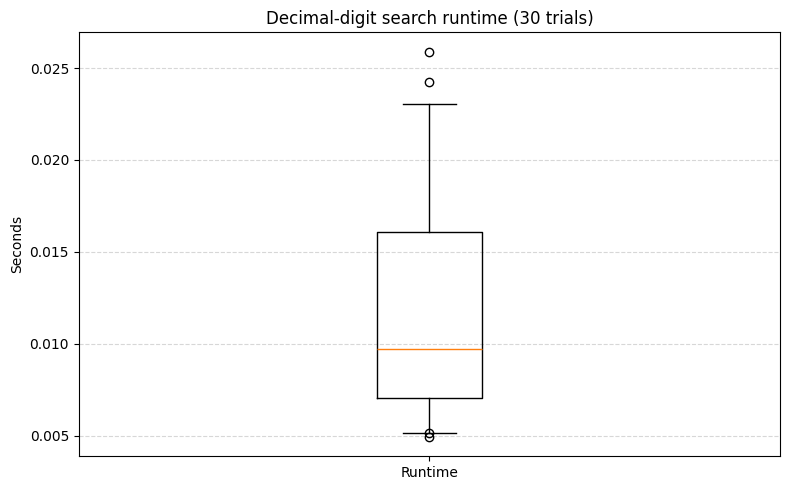

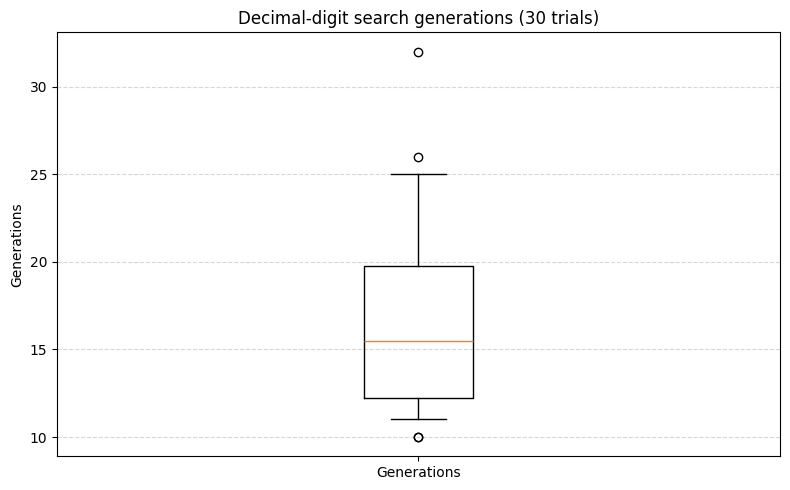

{'mean_best_fitness': 0.9972222222222222,
 'mean_runtime': 0.011992716665069262,
 'convergence_rate': 0.9666666666666667}

In [21]:
decimal_outcomes = run_decimal_experiment()
save_decimal_plots(decimal_outcomes)
mean_fitness = statistics.mean(outcome.best_fitness for outcome in decimal_outcomes)
mean_time = statistics.mean(outcome.elapsed_seconds for outcome in decimal_outcomes)
convergence_rate = sum(outcome.converged for outcome in decimal_outcomes) / len(decimal_outcomes)

{
    "mean_best_fitness": mean_fitness,
    "mean_runtime": mean_time,
    "convergence_rate": convergence_rate,
}


## Answers to Guiao – Exercise 3

- **Evaluation changes**: Fitness compares decimal digits position-wise, producing the fraction of matching digits. Exact matches score 1.0.
- **Mutation changes**: Each mutation swaps one digit with a different digit (sampled from the remaining nine possibilities), ensuring the candidate actually changes.
- **Crossover changes**: Single-point crossover remains applicable: parent prefixes/suffixes combine into a child of equal length.
- **Behaviour in practice**: Across 30 seeds on a 12-digit target, the algorithm reliably reaches the exact solution with modest runtime and generations. Boxplots saved under `Exercicio3/output/` document runtime and generation distributions.



### Observations
- Extending to decimal digits increases the branching factor but the operators remain effective.
- Mutation must sample from the remaining nine digits to ensure actual changes.
- Selection with crossover continues to reach the exact solution in most trials within a moderate number of generations.
